In [139]:
import pandas as pd
import numpy as np
import os
import math
import random

os.makedirs('lb_calcs', exist_ok=True)

# From Trampush et al., 2014
Trampush_velocities = {
    '50':1.2843137254901962,
    '25':0.8413867822318526,
    '75':1.6939077776156426
}

trampush_2014 = pd.read_csv('3rd_party/trampush_2014_utf8.csv')
trampush_WD = np.nanmean(trampush_2014['Wbf [m]']/trampush_2014['Hbf [m]']) # Average width to depth ratio

a0 = -2.08
a1 = 0.254
a2 = -1.09

D50_trampush = lambda Hbf, slope: np.exp((np.log10(slope) - a0 - (a2 * np.log10(Hbf)))/a1) # invert for D50 (mm)


seconds_in_month = 2629800

R = 1.65 # Submerged specific gravity for quartz
g = 9.81 # gravity

rho = 1000 # density of water (kg/m^3)
ps =  2650 # density of sediment (kg/m^3)
t_crit = 0.03 # critical shields stress

def estimate_tc(row):
    # Lamb et al., 2008
    return np.power(0.15*row['S upstream [-]'], 0.25)
    
Hbf_Dunne = lambda S, tc, rho, g: (1.2*tc)/(rho*g*S)

def Hbf_K_and_J(row): 
    return Hbf_Dunne(row['S upstream [-]'], row['t_c_bank'], rho, g)

def Hbf_velocity(row):
    if row['discharge [cms]'] > 5:
        return row['discharge [cms]']/row['U [m/s]']/row['Width [m]']
    else:
        return row['Width [m]']/trampush_WD

def Hbf_Yamazaki(row):
    Hbf_est = 0.5*np.power(row['discharge [cms]'], 0.3)
    if Hbf_est < 1:
        Hbf_est = 1
    return Hbf_est

def Wbf_Yamazaki(row):
    Wbf_est = 15*np.power(row['discharge [cms]'], 0.5)
    if Wbf_est < 10:
        Wbf_est = 10
    return Wbf_est
        
def tb_depth_slope(row):
    return rho*g*row['Hbf [m]']*row['S [-]']

def get_D50(row):
    D50_regression = float(D50_trampush(row['Hbf [m]'], row['S [-]']))/float(1000)
    D50_shields = (row['t_b']/(row['t_c']*(ps-rho)*g))

    if random.randrange(0, 2, 1):
        return D50_regression
    else:
        return D50_shields
    
def estimate_Cf(row):
    return (g*row['S upstream [-]']*row['Hbf [m]'])/np.power(row['U [m/s]'], 2)

def L_b(row):
    return row['Hbf [m]']/row['S upstream [-]']/1000

def S_ratio(row):
    return row['S upstream [-]']/row['S downstream [-]']

In [141]:
# Monte Carlo Simulations

global_avulsions = pd.read_csv(os.path.join('data', 'global_avulsion_db_width_est.csv'))
global_avulsions = global_avulsions.loc[global_avulsions['Wbf'] > 0]

num_reps = 200

df_all = pd.DataFrame()

for rid, row in global_avulsions.iterrows():

    # Uniform distribution of slope within IQR
    
    print(row['Av_ID'])
    
    S_upstream = []
    S_downstream = []
    
    if row['S (recorded) [-]'] > 0:
        
        if row['Upstream S_IQR [-]'] > 0:
            
            lower_bound = row['S (recorded) [-]']-(row['S_IQR (recorded) [-]']*0.5)
            upper_bound = row['S (recorded) [-]']+(row['S_IQR (recorded) [-]']*0.5)

            while len(S_upstream)<num_reps:
                slope = random.uniform(lower_bound, upper_bound)
                if slope > 0:
                    S_upstream.append(slope)
        else:
            
            S_upstream = [row['S (recorded) [-]']]*num_reps
            
    else:
        if row['Upstream S_IQR [-]'] > 0:

            lower_bound = row['Upstream S [-]']-(row['Upstream S_IQR [-]']*0.5)
            upper_bound = row['Upstream S [-]']+(row['Upstream S_IQR [-]']*0.5)

            while len(S_upstream)<num_reps:
                slope = random.uniform(lower_bound, upper_bound)
                if slope > 0:
                    S_upstream.append(slope)
        else:

            S_upstream = [row['Upstream S [-]']]*num_reps

    if row['Downstream S_IQR [-]'] > 0:

        lower_bound = row['Downstream S [-]']-(row['Downstream S_IQR [-]']*0.5)
        upper_bound = row['Downstream S [-]']+(row['Downstream S_IQR [-]']*0.5)

        while len(S_downstream)<num_reps:
            slope = random.uniform(lower_bound, upper_bound)
            if slope > 0:
                S_downstream.append(slope)
    else:

        S_downstream = [row['Upstream S [-]']]*num_reps
            
    # Uniform distribution of widths using standard deviation
        
    if row['Width_std [m]'] > 0:
        widths = np.random.normal(row['Wbf'], row['Width_std [m]'], num_reps)
    else:
        widths = [row['Wbf']]*num_reps

    df = pd.DataFrame({'S upstream [-]': S_upstream, 'S downstream [-]':S_downstream,'Width [m]': widths})
    
    df['Av_ID'] = row['Av_ID']
    df['River'] = row['River']
    df['L_A [km]'] = row['L_A [km]']
    df['L_A_error [km]'] = row['L_A_error [km]']
    
    if row['geomorph_type'] == 'fan':
        df['geomorph'] = 1
    elif row['geomorph_type'] == 'delta':
        df['geomorph'] = 2
    else:
        df['geomorph'] = 3
    
    df['S_ratio'] = df.apply(S_ratio, axis=1)
    
#     df['t_c'] = df.apply(estimate_tc, axis=1)
    df['t_c'] = t_crit
  
    t_c_bank = []
    
    for _ in range(num_reps): t_c_bank.append(random.randrange(6, 11, 1))
    
    df['t_c_bank'] = t_c_bank    
    
    flood_multiple = []
    for _ in range(num_reps): flood_multiple.append(random.randrange(2, 5, 1)) # Floods are between 2 and 4 time bankfull
    # e.g. (Gibling 2006; Ganti et al. 2014a; Trower et al. 2018; Ganti et al., 2019)

    df['flood_multiple'] = flood_multiple
    
    # Flow velocity
    
    U = []
    for _ in range(num_reps): U.append(random.uniform(Trampush_velocities['25'], Trampush_velocities['75']))
    df['U [m/s]'] = U
    
    df['discharge [cms]'] = row['discharge [cms]']
    
    if (row['From'] != 'madagascar'):
        df['Hbf (recorded) [m]'] = row['Hbf [m] (recorded)']
    else:
        df['Hbf (recorded) [m]'] = 0
        
    if row['Hbf [m] (recorded)'] > 0:  
        df['Hbf [m]'] = row['Hbf [m] (recorded)']
    else:
        df['Hbf [m]'] = df.apply(Hbf_Yamazaki, axis=1)
        
    df['Wbf est [m]'] = df.apply(Wbf_Yamazaki, axis=1)
    

    df['Hbf (Yamazaki) [m]'] = df.apply(Hbf_Yamazaki, axis=1)
    df['Hbf (velocity) [m]'] = df.apply(Hbf_velocity, axis=1)
    df['Hbf (K&J) [m]'] = df.apply(Hbf_K_and_J, axis=1)
    
    
    df['L_b [km]'] = df.apply(L_b, axis=1)
    
    df.to_csv(os.path.join('lb_calcs', row.Av_ID+'.csv'))
              
    df_all = df_all.append(df)



AFR0211_1998
ANGO2_2003
ARG_001_2001
BETSIBOKA_2004
BS0115_1995
CA0067_1986
CA0194_2007
CA0318-1_2002
CASP1_1991
CHI_001_1992
CON_001_2013
CON_002
DANUBE
ECN0095_1999
FIHERENANA_2001
HUANGHE_1930
JA_1_Taquari_1990_1990
JA_10_Iran_2009_2009
JA_12_Eritrea
JA_18_PNG_1994_1994
JA_2_Taquari_1998
JA_25_India_1990_2000_2008_2011_1990
JA_26_Ethiopia_1989_2002_2005_2007_1989
JA_28_Eritrea_1997_1997
JA_30_Eritrea_2007_2007
JA_34_Morocco_2001_2001
JA_35_Madagascar_2000_2000
JA_36_Eritrea_2005_2005
JA_37_Somalia_1989_1989
JA_38_Madagascar_1994_1994
JA_4_Kosi_2008_2008
JA_40_NewGuinea_Madang_1989_1989
JA_69_PNG_2004_2009_2004
JA_8_India_2004_2004
JA_81_DeinNewGuinea_2002_2002
JA_82_DeinNewGuinea_2012
JA_86_Philippines_1996_1996
JA_91_Peru_1998
JA_94_Iran
JA_95_PNG_1989_1989
JAVA12_1985
JAVA2_1984
JAVA3_1992
JAVA4_1973
JAVA5_1995
JAVA5_1998
JAVA5_2018
JAVA6_2010
JAVA7_1982
JAVA7_1990
JAVA7_2010
JAVA8_2018
JAVA9_2014
KAZ_001_1993
KAZ_007_2020
KAZ_014_2011
KEN_001_1989
MAGDALENA
MAHAJAMBA_2004
MALAWI1

In [142]:
def IQR(dat):
    return np.nanpercentile(dat, 75)-np.nanpercentile(dat, 25)

df_grouped = df_all.groupby("Av_ID").agg([np.nanmedian, IQR, np.mean, np.std])

# avocado_prices.plot(kind = "scatter", y = "mean", legend = False, title = "Test", xerr = "std")

df_grouped

df_grouped.to_csv('Lb_only.csv')

/usr/local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


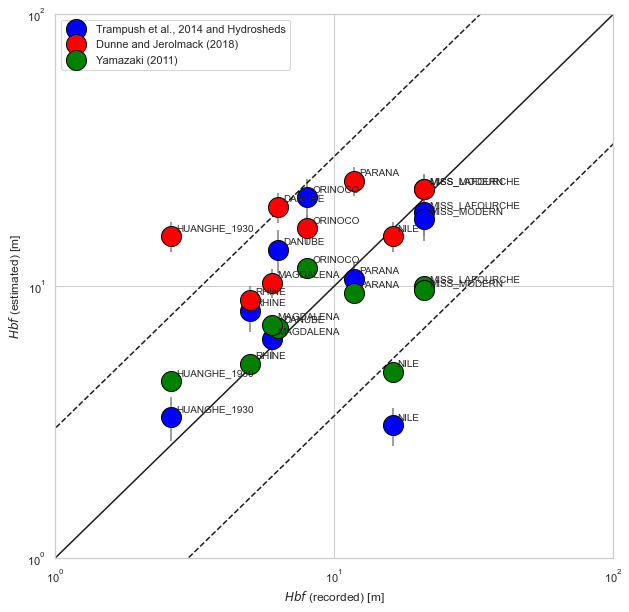

In [143]:
# Depth estimation vs. recorded

df_all_depth_recorded = df_all.loc[df_all['Hbf (recorded) [m]'] > 0 ]
df_grouped_depth_recorded = df_all_depth_recorded.groupby("Av_ID").agg([np.nanmedian, IQR, np.mean, np.std])

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xscale("log", nonpositive='clip')
ax.set_yscale("log", nonpositive='clip')

refplot = np.linspace(.01,1000,1000)
refplot_upper = refplot*3
refplot_lower = refplot/3

ax.plot(refplot,refplot, color='k')
ax.plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax.plot(refplot, refplot_lower, color='k', linestyle='dashed') 

annotate_text = []

ax.errorbar(df_grouped_depth_recorded['Hbf (recorded) [m]']['nanmedian'], 
            df_grouped_depth_recorded['Hbf (velocity) [m]']['nanmedian'], 
            xerr=df_grouped_depth_recorded['Hbf (recorded) [m]']['IQR']/2, 
            yerr=df_grouped_depth_recorded['Hbf (velocity) [m]']['IQR']/2, 
            fmt='o', ms=20, markerfacecolor='blue', ecolor='grey', 
            markeredgecolor='black', label='Trampush et al., 2014 and Hydrosheds')

ax.errorbar(df_grouped_depth_recorded['Hbf (recorded) [m]']['nanmedian'], 
            df_grouped_depth_recorded['Hbf (K&J) [m]']['nanmedian'], 
            xerr=df_grouped_depth_recorded['Hbf (recorded) [m]']['IQR']/2, 
            yerr=df_grouped_depth_recorded['Hbf (K&J) [m]']['IQR']/2, 
            fmt='o', ms=20, markerfacecolor='red', ecolor='grey', 
            markeredgecolor='black', label='Dunne and Jerolmack (2018)')

ax.errorbar(df_grouped_depth_recorded['Hbf (recorded) [m]']['nanmedian'], 
            df_grouped_depth_recorded['Hbf (Yamazaki) [m]']['nanmedian'], 
            xerr=df_grouped_depth_recorded['Hbf (recorded) [m]']['IQR']/2, 
            yerr=df_grouped_depth_recorded['Hbf (Yamazaki) [m]']['IQR']/2, 
            fmt='o', ms=20, markerfacecolor='green', ecolor='grey', 
            markeredgecolor='black', label='Yamazaki (2011)')

plt.grid('on')
ax.set_xlabel('$Hbf$ (recorded) [m]')
ax.set_ylabel('$Hbf$ (estimated) [m]')
ax.set_ylim(bottom=1, top=100)
ax.set_xlim(left=1, right=100)

for idx, row in df_grouped_depth_recorded.iterrows():
    ax.annotate(idx, xy=(row['Hbf (recorded) [m]']['nanmedian'],row['Hbf (K&J) [m]']['nanmedian']), 
                xytext=(5, 5), xycoords='data', textcoords='offset points', fontsize=10)
    ax.annotate(idx, xy=(row['Hbf (recorded) [m]']['nanmedian'],row['Hbf (velocity) [m]']['nanmedian']), 
                xytext=(5, 5), xycoords='data', textcoords='offset points', fontsize=10)
    ax.annotate(idx, xy=(row['Hbf (recorded) [m]']['nanmedian'],row['Hbf (Yamazaki) [m]']['nanmedian']), 
                xytext=(5, 5), xycoords='data', textcoords='offset points', fontsize=10)
        
    

    ax.legend()
plt.show()

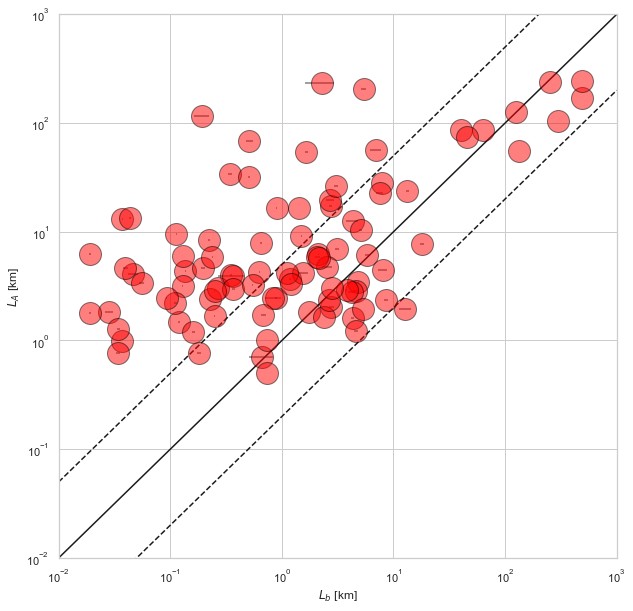

In [144]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xscale("log", nonpositive='clip')
ax.set_yscale("log", nonpositive='clip')

refplot = np.linspace(.01,1000,1000)
refplot_upper = refplot*5
refplot_lower = refplot/5

ax.plot(refplot,refplot, color='k')
ax.plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax.plot(refplot, refplot_lower, color='k', linestyle='dashed') 

annotate_text = []

ax.errorbar(df_grouped['L_b [km]']['nanmedian'], df_grouped['L_A [km]']['nanmedian'], xerr=df_grouped['L_b [km]']['IQR']/2, yerr=df_grouped['L_A [km]']['IQR']/2, 
            fmt='o', ms=22, markerfacecolor='red', ecolor='black', markeredgecolor='black', alpha=0.5)

plt.grid('on')
ax.set_xlabel('$L_b$ [km]')
ax.set_ylabel('$L_A$ [km]')
ax.set_ylim(bottom=.01, top=1000)
ax.set_xlim(left=.01, right=1000)

# for idx, row in df_grouped.iterrows():
#     ax.annotate(idx, xy=(row['L_b [km]']['nanmedian'],
#                          row['L_A [km]']['nanmedian']), 
#                 xytext=(5, 5), xycoords='data', textcoords='offset points',
#                fontsize=10)
    
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xscale("log", nonpositive='clip')
ax.set_yscale("log", nonpositive='clip')

refplot = np.linspace(.01,1000,1000)
refplot_upper = refplot*5
refplot_lower = refplot/5

ax.plot(refplot,refplot, color='k')
ax.plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax.plot(refplot, refplot_lower, color='k', linestyle='dashed') 

annotate_text = []

ax.boxplot(df_grouped['L_b [km]']['nanmedian'], df_grouped['L_A [km]']['nanmedian'], xerr=df_grouped['L_b [km]']['IQR']/2, yerr=df_grouped['L_A [km]']['IQR']/2, 
            fmt='o', ms=22, markerfacecolor='red', ecolor='black', markeredgecolor='black', alpha=0.5)

plt.grid('on')
ax.set_xlabel('$L_b$ [km]')
ax.set_ylabel('$L_A$ [km]')
ax.set_ylim(bottom=.01, top=1000)
ax.set_xlim(left=.01, right=1000)

# for idx, row in df_grouped.iterrows():
#     ax.annotate(idx, xy=(row['L_b [km]']['nanmedian'],
#                          row['L_A [km]']['nanmedian']), 
#                 xytext=(5, 5), xycoords='data', textcoords='offset points',
#                fontsize=10)
    
plt.show()

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


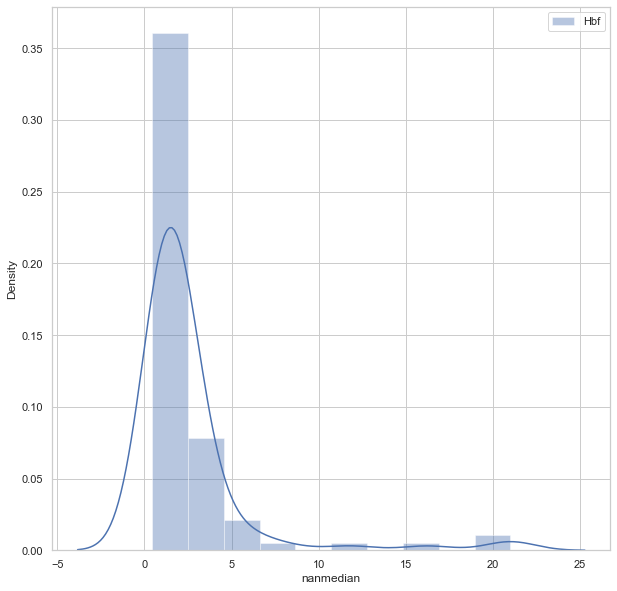

In [145]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 10), nrows=1, ncols=1, sharey=True)

cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
g = sns.distplot(df_grouped['Hbf [m]']['nanmedian'],
    ax=ax,
    label='Hbf',
    bins=10
)
plt.legend()
plt.show()



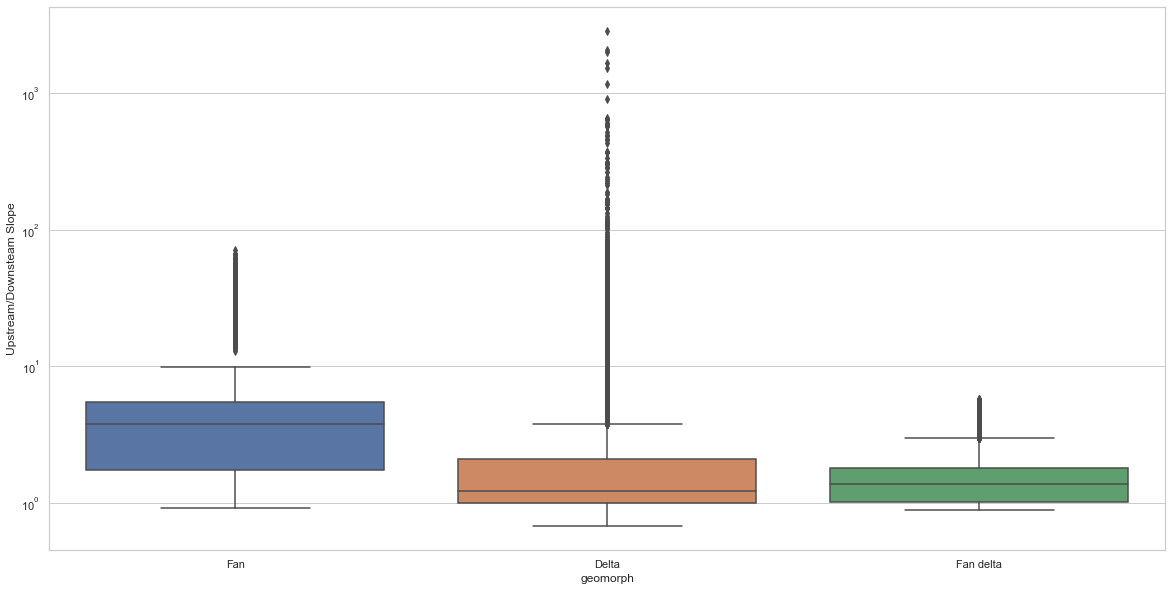

In [146]:
fig, ax = plt.subplots(figsize=(20, 10), nrows=1, ncols=1, sharey=True)

ax = sns.boxplot(x="geomorph", y="S_ratio", data=df_all)
ax.set_xticklabels(['Fan', 'Delta', 'Fan delta'])
ax.set_ylabel('Upstream/Downsteam Slope')
ax.set_yscale("log", nonpositive='clip')


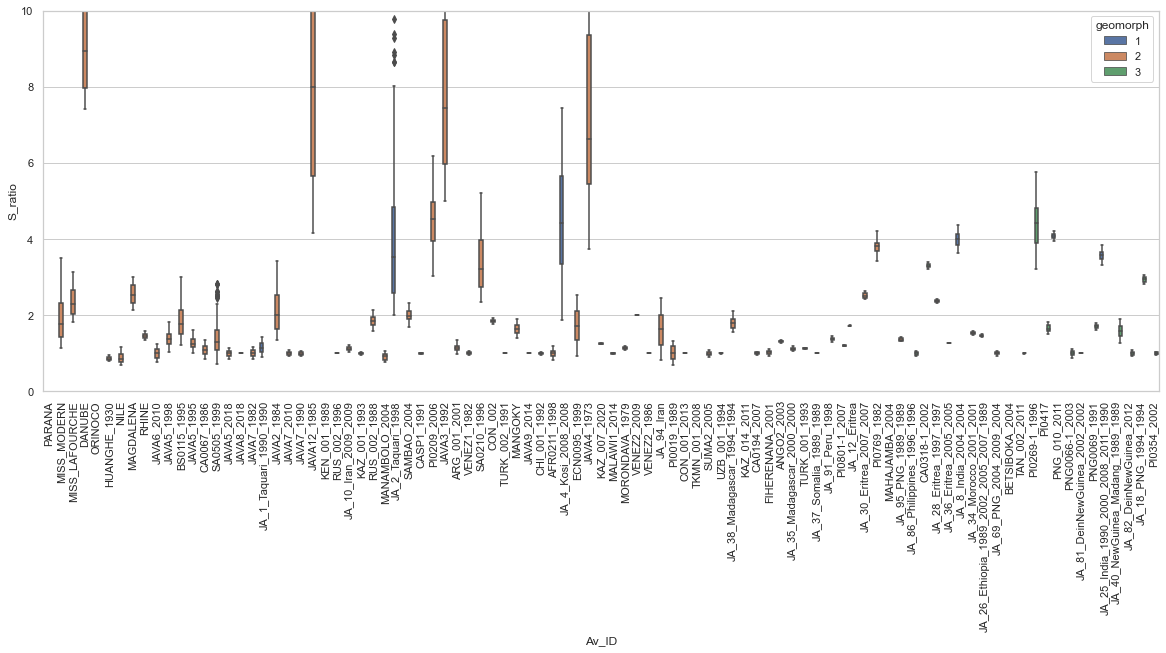

In [147]:
fig, ax = plt.subplots(figsize=(20, 7), nrows=1, ncols=1, sharey=True)

df_all = df_all.sort_values('S upstream [-]')
sns.boxplot(x="Av_ID", y="S_ratio", data=df_all, ax=ax, hue='geomorph')
ax.set_ylim([0,10])
plt.xticks(rotation = 90)
plt.show()

In [148]:
df_grouped_no_fan = df_grouped.loc[df_grouped['geomorph']['mean'] > 1]

In [149]:
gt_2_times_LB = df_grouped_no_fan.loc[df_grouped_no_fan['L_A [km]']['mean']>df_grouped_no_fan['L_b [km]']['mean']*2]
lt_2_times_LB = df_grouped_no_fan.loc[df_grouped_no_fan['L_A [km]']['mean']<(df_grouped_no_fan['L_b [km]']['mean']*2)]

<ipython-input-150-f4ec7fdc6a87>:4: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx='clip')


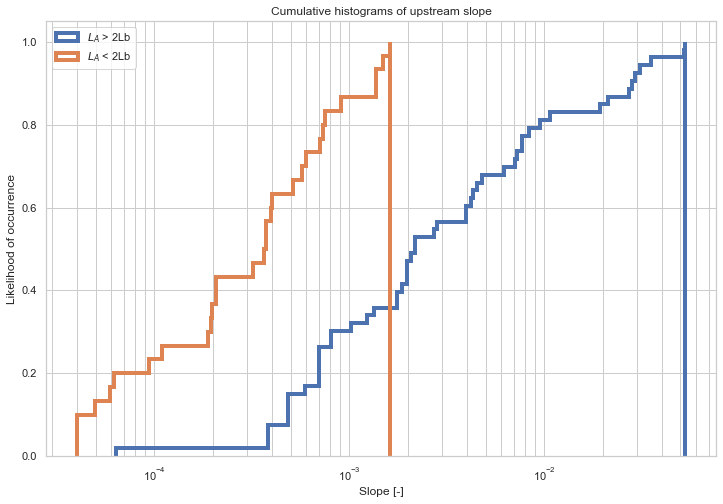

In [150]:
bins = 500

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xscale("log", nonposx='clip')

ax.hist(gt_2_times_LB['S upstream [-]']['mean'], bins, label='$L_A$ > 2Lb', cumulative=True, density=True, histtype='step', linewidth=4)
ax.hist(lt_2_times_LB['S upstream [-]']['mean'], bins, label='$L_A$ < 2Lb', cumulative=True, density=True, histtype='step', linewidth=4)
ax.legend(loc='upper right')
ax.legend(loc='upper left')
ax.set_title('Cumulative histograms of upstream slope')
ax.set_xlabel('Slope [-]')
ax.set_ylabel('Likelihood of occurrence')
# ax.set_xlim([0.00001,0.03])
ax.grid(True)
plt.grid(True, which="both")
plt.show()


<ipython-input-151-eafa6abc8623>:52: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx='clip')
<ipython-input-151-eafa6abc8623>:53: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", nonposy='clip')


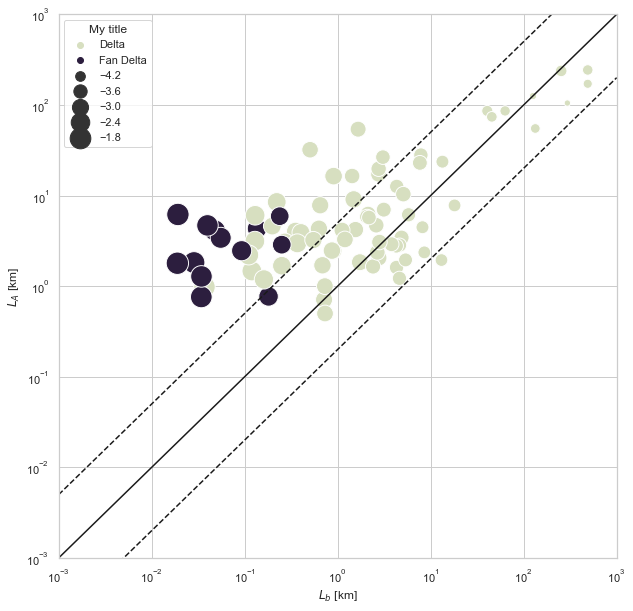

In [151]:
Av_ID = []
LA = []
lb_mean = []
S_mean = []
lscour_mean = []
lb_std = []
tadj_std = []
geomorph = []
discharges = []
width_measured = []
width_estimated = []
LA_over_LB = []

for idx, r in df_grouped_no_fan.iterrows():
    Av_ID.append(idx)
    LA.append(r['L_A [km]']['mean'])
    LA_over_LB.append(r['L_A [km]']['mean']/r['L_b [km]']['mean'])
    S_mean.append(r['S upstream [-]']['mean'])
    geomorph.append(r['geomorph']['mean'])
    lb_mean.append(r['L_b [km]']['mean'])
    lb_std.append(r['L_b [km]']['std'])
    discharges.append(r['discharge [cms]']['mean'])
    width_measured.append(r['Width [m]']['mean'])
    width_estimated.append(r['Wbf est [m]']['mean'])
    
mean_value_df = pd.DataFrame({'Av_ID':Av_ID,
                              'slope':S_mean,
                              'LA':LA,
                              'LA_over_LB':LA_over_LB,
                              'geomorph':geomorph,
                             'L_b [km]':lb_mean, 
                              'L_b_std_dev [km]':lb_std,
                             'discharge':discharges,
                             'Width_measured':width_measured,
                             'Width_estimated':width_estimated})

mean_value_df = mean_value_df.set_index('Av_ID')
global_avulsions_pop = global_avulsions.merge(mean_value_df, on='Av_ID')

global_avulsions_pop_plot = global_avulsions_pop.copy()

global_avulsions_pop_plot['S_size'] = np.log10(global_avulsions_pop_plot['Upstream S [-]'])

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Draw a scatter plot while assigning point colors and sizes to different
# variables in the dataset
fig, ax = plt.subplots(figsize=(10, 10), nrows=1, ncols=1, sharey=True)

ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
g = sns.scatterplot(
    y="L_A [km]", x="L_b [km]_y",
    hue='geomorph',
    size=global_avulsions_pop_plot['S_size'].values,
    palette=cmap, sizes=(40, 500),
    data=global_avulsions_pop_plot,
    ax=ax
)

refplot = np.linspace(.001,1000,1000)
refplot_upper = refplot*5
refplot_lower = refplot/5
ax.plot(refplot,refplot, color='k')
ax.plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax.plot(refplot, refplot_lower, color='k', linestyle='dashed')
ax.set_xlabel('$L_{b}$ [km]')
ax.set_ylabel('$L_A$ [km]')
ax.set_ylim(bottom=.001, top=1000)
ax.set_xlim(left=.001, right=1000)
# ax[0].set_title('$L_A$ against $L_{scour}$ - With best guesses')

# title
leg = g.axes.get_legend()
new_title = 'My title'
leg.set_title(new_title)
# replace labels
new_labels = ['Delta', 'Fan Delta']
for t, l in zip(leg.texts, new_labels): t.set_text(l)
    
plt.show()

<ipython-input-152-7bc35f39d733>:4: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx='clip')
<ipython-input-152-7bc35f39d733>:5: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", nonposy='clip')


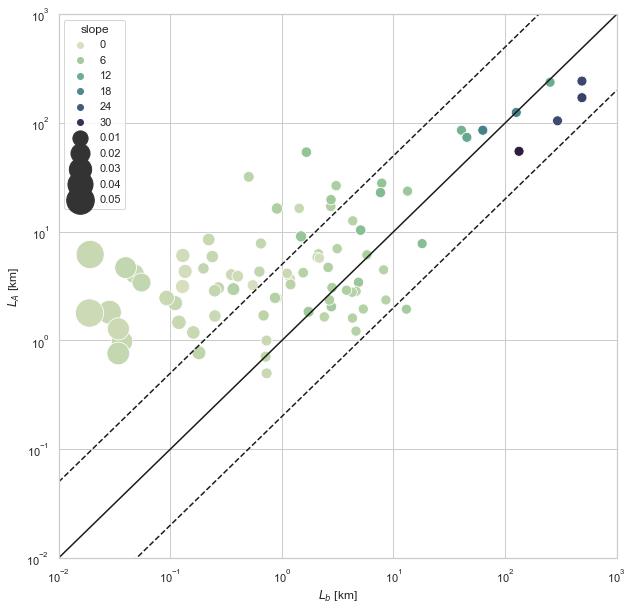

In [152]:
fig, ax = plt.subplots(figsize=(10, 10), nrows=1, ncols=1, sharey=True)
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 18})
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

global_avulsions_pop_plot['discharge_cbrt'] = np.cbrt(global_avulsions_pop_plot['discharge'].values)

cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
g = sns.scatterplot(
    y="L_A [km]", x="L_b [km]_y",
    hue=global_avulsions_pop_plot['discharge_cbrt'].values,
    size='slope',
    palette=cmap, sizes=(100, 800),
    data=global_avulsions_pop_plot,
    ax=ax
)

refplot = np.linspace(.01,1000,1000)
refplot_upper = refplot*5
refplot_lower = refplot/5
ax.plot(refplot,refplot, color='k')
ax.plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax.plot(refplot, refplot_lower, color='k', linestyle='dashed')
ax.set_xlabel('$L_{b}$ [km]')
ax.set_ylabel('$L_A$ [km]')
ax.set_ylim(bottom=.01, top=1000)
ax.set_xlim(left=.01, right=1000)
# ax[0].set_title('$L_A$ against $L_{scour}$ - With best guesses')

# # title
# leg = g.axes.get_legend()
# new_title = 'My title'
# leg.set_title(new_title)
# # replace labels
# new_labels = ['Delta', 'Fan Delta']
# for t, l in zip(leg.texts, new_labels): t.set_text(l)
    
plt.show()

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2595: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.9/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to u

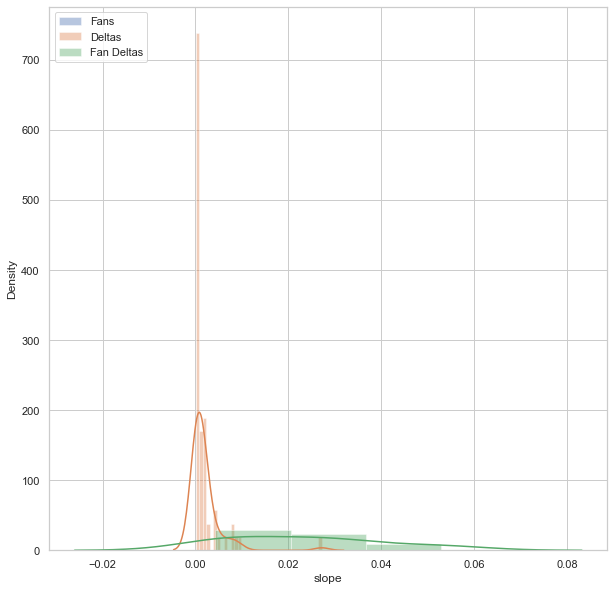

In [153]:
# Draw a scatter plot while assigning point colors and sizes to different
# variables in the dataset
fig, ax = plt.subplots(figsize=(10, 10), nrows=1, ncols=1, sharey=True)

cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
g = sns.distplot(global_avulsions_pop_plot.loc[global_avulsions_pop_plot['geomorph']==1]['slope'],
    ax=ax,
    label='Fans'
)

g2 = sns.distplot(global_avulsions_pop_plot.loc[global_avulsions_pop_plot['geomorph']==2]['slope'],
    ax=ax,
    label='Deltas'
)

g3 = sns.distplot(global_avulsions_pop_plot.loc[global_avulsions_pop_plot['geomorph']==3]['slope'],
    ax=ax,
    label='Fan Deltas'
)

# ax[0].set_title('$L_A$ against $L_{scour}$ - With best guesses')
# ax.set_xlim([0,0.04])
plt.legend()
plt.show()

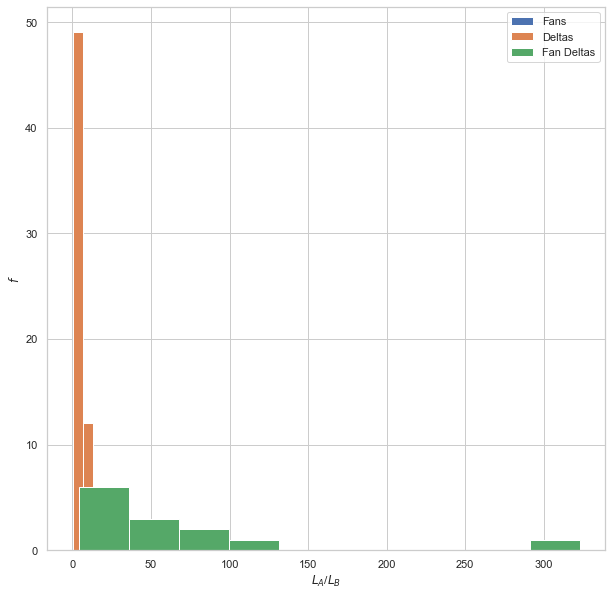

In [154]:
# Draw a scatter plot while assigning point colors and sizes to different
# variables in the dataset
fig, ax = plt.subplots(figsize=(10, 10), nrows=1, ncols=1, sharey=True)

g = ax.hist(global_avulsions_pop_plot.loc[global_avulsions_pop_plot['geomorph']==1]['LA_over_LB'],
       bins=10,
    label='Fans'
)

g2 = ax.hist(global_avulsions_pop_plot.loc[global_avulsions_pop_plot['geomorph']==2]['LA_over_LB'],
    bins=10,
    label='Deltas'
)

g3 = ax.hist(global_avulsions_pop_plot.loc[global_avulsions_pop_plot['geomorph']==3]['LA_over_LB'],
    bins=10,
    label='Fan Deltas'
)

ax.set_xlabel('$L_A$/$L_B$')
ax.set_ylabel('$f$')
plt.legend()
plt.show()

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


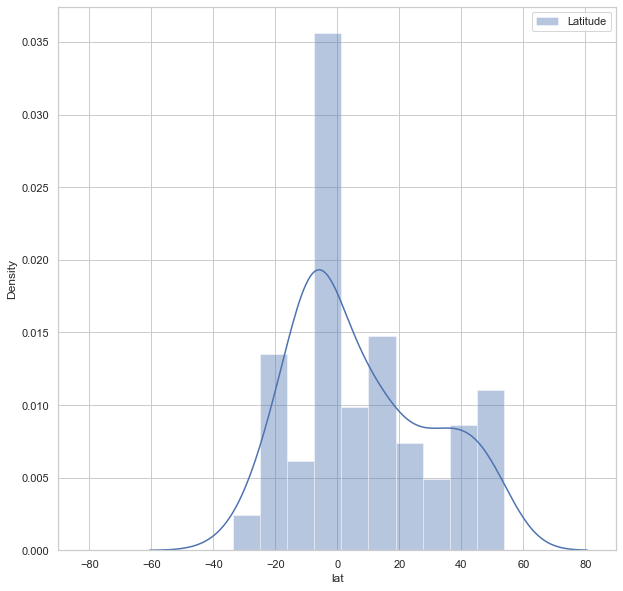

In [113]:

# Draw a scatter plot while assigning point colors and sizes to different
# variables in the dataset
fig, ax = plt.subplots(figsize=(10, 10), nrows=1, ncols=1, sharey=True)

cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
g = sns.distplot(global_avulsions['lat'],
    ax=ax,
    label='Latitude',
    bins=10
)
ax.set_xlim([-90, 90])
plt.legend()
plt.show()


(1, 5000)

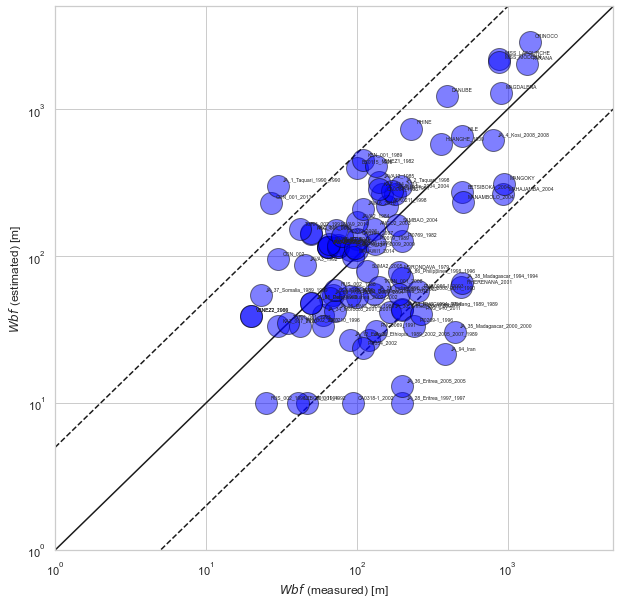

In [155]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xscale("log", nonpositive='clip')
ax.set_yscale("log", nonpositive='clip')

refplot = np.linspace(1,5000,5000)
refplot_upper = refplot*5
refplot_lower = refplot/5

ax.plot(refplot,refplot, color='k')
ax.plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax.plot(refplot, refplot_lower, color='k', linestyle='dashed') 

annotate_text = []

ax.errorbar(df_grouped['Width [m]']['nanmedian'], df_grouped['Wbf est [m]']['nanmedian'], xerr=df_grouped['Width [m]']['IQR']/2, yerr=df_grouped['Wbf est [m]']['IQR']/2, 
            fmt='o', ms=22, markerfacecolor='blue', ecolor='black', markeredgecolor='black', alpha=0.5)

for idx, row in df_grouped.iterrows():
    ax.annotate(idx, xy=(row['Width [m]']['nanmedian'],
                         row['Wbf est [m]']['nanmedian']), 
                xytext=(5, 5), xycoords='data', textcoords='offset points',
               fontsize=5)
    
plt.grid('on')
ax.set_xlabel('$Wbf$ (measured) [m]')
ax.set_ylabel('$Wbf$ (estimated) [m]')
ax.set_ylim(bottom=1, top=5000)
ax.set_xlim(left=1, right=5000)

<ipython-input-156-d1258b1a5d5e>:4: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx='clip')
<ipython-input-156-d1258b1a5d5e>:5: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", nonposy='clip')


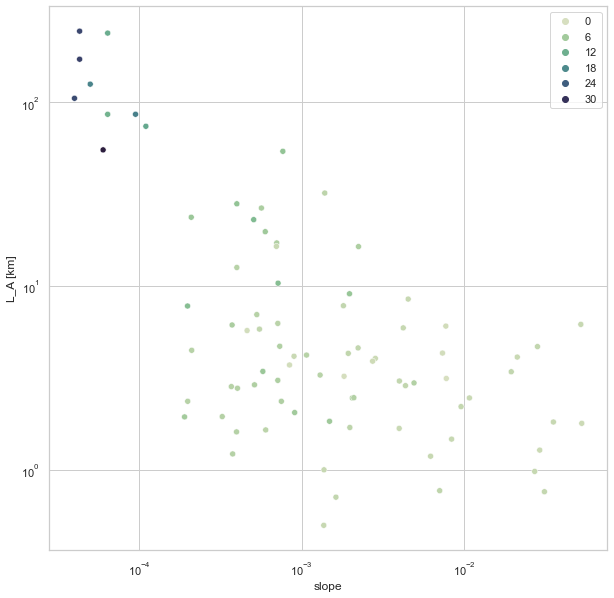

In [156]:
fig, ax = plt.subplots(figsize=(10, 10), nrows=1, ncols=1, sharey=True)
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 18})
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

global_avulsions_pop_plot['discharge_cbrt'] = np.cbrt(global_avulsions_pop_plot['discharge'].values)

cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
g = sns.scatterplot(
    y="L_A [km]", x="slope",
    hue=global_avulsions_pop_plot['discharge_cbrt'].values,
    palette=cmap, sizes=(100, 800),
    data=global_avulsions_pop_plot,
    ax=ax
)

# refplot = np.linspace(1,5000,1000)
# refplot_upper = refplot*5
# refplot_lower = refplot/5
# ax.plot(refplot,refplot, color='k')
# ax.plot(refplot,refplot_upper, color='k', linestyle='dashed')
# ax.plot(refplot, refplot_lower, color='k', linestyle='dashed')
# ax.set_ylabel('Width (estimated) [m]')
# ax.set_xlabel('Width (measured) [m]')
# ax.set_ylim(bottom=1, top=5000)
# ax.set_xlim(left=1, right=5000)
# ax[0].set_title('$L_A$ against $L_{scour}$ - With best guesses')

# # title
# leg = g.axes.get_legend()
# new_title = 'My title'
# leg.set_title(new_title)
# # replace labels
# new_labels = ['Delta', 'Fan Delta']
# for t, l in zip(leg.texts, new_labels): t.set_text(l)
    
plt.show()

<ipython-input-157-e4dbf06008f6>:4: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx='clip')
<ipython-input-157-e4dbf06008f6>:5: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", nonposy='clip')


ValueError: Could not interpret value `Sl [km]` for parameter `x`

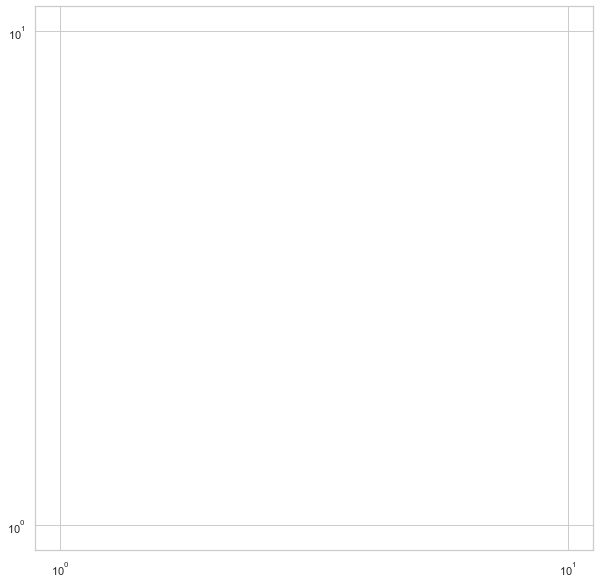

In [157]:
fig, ax = plt.subplots(figsize=(10, 10), nrows=1, ncols=1, sharey=True)
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 18})
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

global_avulsions_pop_plot['discharge_cbrt'] = np.cbrt(global_avulsions_pop_plot['discharge'].values)

cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
g = sns.scatterplot(
    y="L_b [km]", x="Sl [km]",
    hue=global_avulsions_pop_plot['discharge_cbrt'].values,
    size='slope',
    palette=cmap, sizes=(100, 800),
    data=global_avulsions_pop_plot,
    ax=ax
)

refplot = np.linspace(1,5000,1000)
refplot_upper = refplot*5
refplot_lower = refplot/5
ax.plot(refplot,refplot, color='k')
ax.plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax.plot(refplot, refplot_lower, color='k', linestyle='dashed')
ax.set_ylabel('Width (estimated) [m]')
ax.set_xlabel('Width (measured) [m]')
ax.set_ylim(bottom=1, top=5000)
ax.set_xlim(left=1, right=5000)
# ax[0].set_title('$L_A$ against $L_{scour}$ - With best guesses')

# # title
# leg = g.axes.get_legend()
# new_title = 'My title'
# leg.set_title(new_title)
# # replace labels
# new_labels = ['Delta', 'Fan Delta']
# for t, l in zip(leg.texts, new_labels): t.set_text(l)
    
plt.show()

<ipython-input-158-bc3c662e7b03>:44: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax[1].set_xscale("log", nonposx='clip')
<ipython-input-158-bc3c662e7b03>:45: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax[1].set_yscale("log", nonposy='clip')


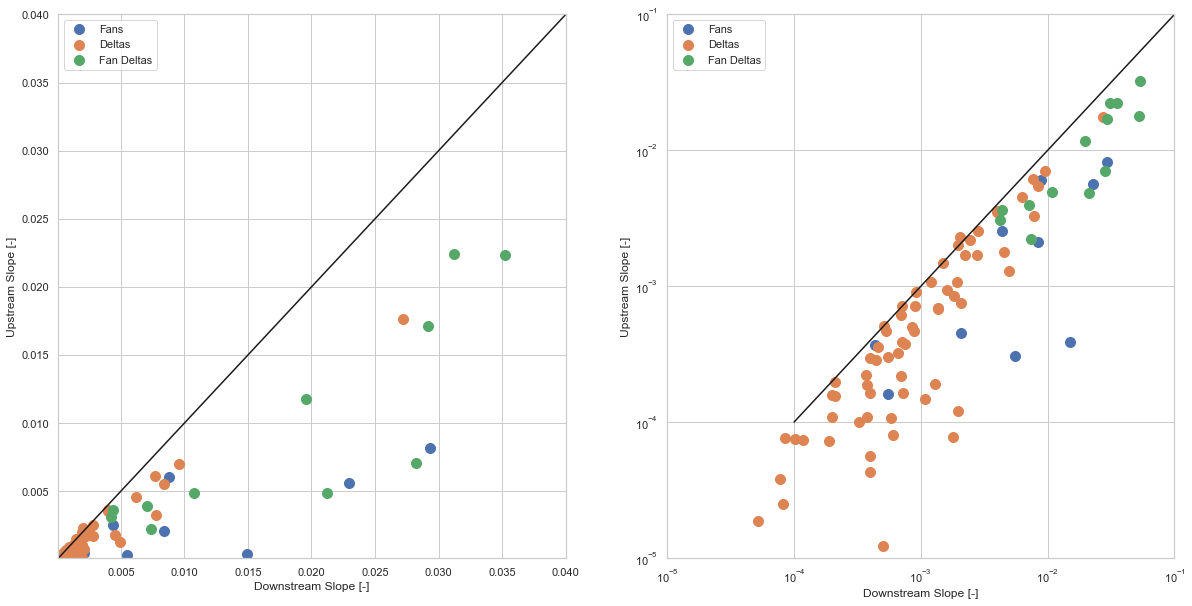

In [158]:
# Slope ratios


def slope_ratio(row):
    return row['Upstream S [-]']/row['Downstream S [-]']
    
global_avulsions['S_ratio'] = global_avulsions.apply(slope_ratio, axis=1)

# Draw a scatter plot while assigning point colors and sizes to different
# variables in the dataset
fig, ax = plt.subplots(figsize=(20, 10), nrows=1, ncols=2, sharey=False)

refplot = np.linspace(1e-4,1,num=2)
# refplot_upper = refplot*5
# refplot_lower = refplot

ax[0].plot(refplot,refplot, color='k')

g = ax[0].scatter(global_avulsions.loc[global_avulsions['geomorph_type']=='fan']['Upstream S [-]'],
                global_avulsions.loc[global_avulsions['geomorph_type']=='fan']['Downstream S [-]'],
    label='Fans',
    s=100
)

g2 = ax[0].scatter(global_avulsions.loc[global_avulsions['geomorph_type']=='delta']['Upstream S [-]'],
                global_avulsions.loc[global_avulsions['geomorph_type']=='delta']['Downstream S [-]'],
    label='Deltas',
    s=100
)

g3 = ax[0].scatter(global_avulsions.loc[global_avulsions['geomorph_type']=='fan_delta']['Upstream S [-]'],
                global_avulsions.loc[global_avulsions['geomorph_type']=='fan_delta']['Downstream S [-]'],
    label='Fan Deltas',
    s=100
)


ax[0].set_ylim(bottom=1e-4, top=0.04)
ax[0].set_xlim(left=1e-4, right=0.04)
ax[0].set_ylabel('Upstream Slope [-]')
ax[0].set_xlabel('Downstream Slope [-]')
ax[0].legend()

ax[1].set_xscale("log", nonposx='clip')
ax[1].set_yscale("log", nonposy='clip')

ax[1].plot(refplot,refplot, color='k')

g = ax[1].scatter(global_avulsions.loc[global_avulsions['geomorph_type']=='fan']['Upstream S [-]'],
                global_avulsions.loc[global_avulsions['geomorph_type']=='fan']['Downstream S [-]'],
    label='Fans',
    s=100
)

g2 = ax[1].scatter(global_avulsions.loc[global_avulsions['geomorph_type']=='delta']['Upstream S [-]'],
                global_avulsions.loc[global_avulsions['geomorph_type']=='delta']['Downstream S [-]'],
    label='Deltas',
    s=100
)

g3 = ax[1].scatter(global_avulsions.loc[global_avulsions['geomorph_type']=='fan_delta']['Upstream S [-]'],
                global_avulsions.loc[global_avulsions['geomorph_type']=='fan_delta']['Downstream S [-]'],
    label='Fan Deltas',
    s=100
)

ax[1].set_ylim(bottom=1e-5, top=0.1)
ax[1].set_xlim(left=1e-5, right=0.1)
ax[1].set_ylabel('Upstream Slope [-]')
ax[1].set_xlabel('Downstream Slope [-]')
ax[1].legend()

plt.show()

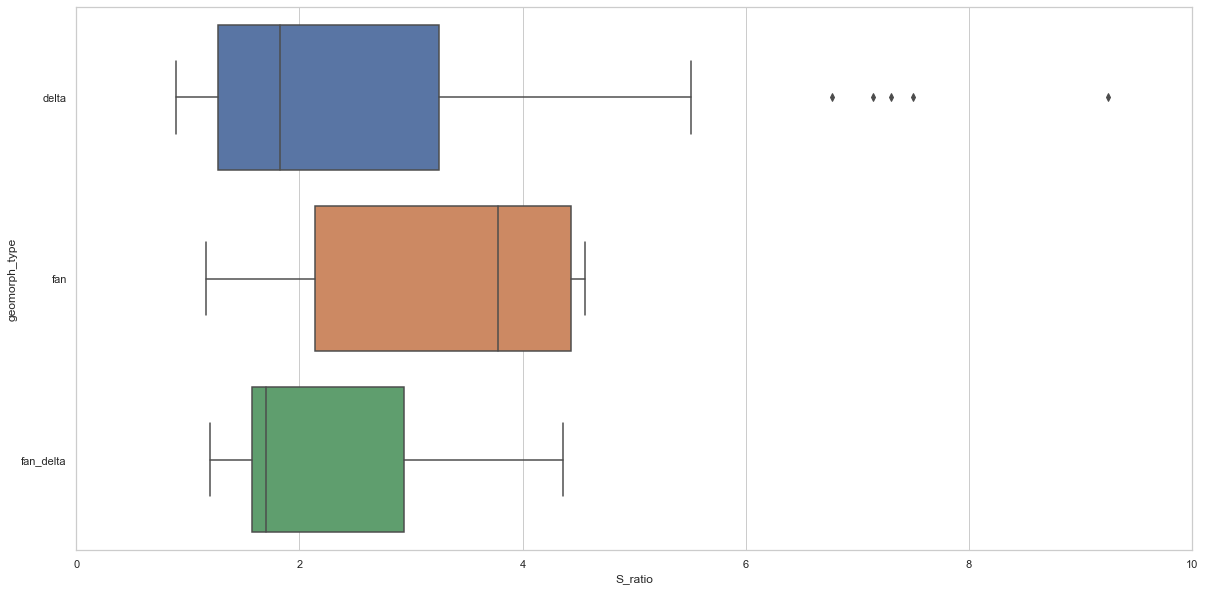

In [159]:
global_avulsions['S_ratio'] = global_avulsions['Upstream S [-]']/global_avulsions['Downstream S [-]']


# Slope ratios


def slope_ratio(row):
    return row['Upstream S [-]']/row['Downstream S [-]']
    
global_avulsions['S_ratio'] = global_avulsions.apply(slope_ratio, axis=1)

# Draw a scatter plot while assigning point colors and sizes to different
# variables in the dataset
fig, ax = plt.subplots(figsize=(20, 10), nrows=1, ncols=1, sharey=False)

ax = sns.boxplot(x="S_ratio", y="geomorph_type", data=global_avulsions)

# ax[1].set_ylim(bottom=1e-5, top=0.1)
ax.set_xlim(left=0, right=10)
plt.show()
